In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module
import multiprocessing

import torch
from torch import Tensor
import torch.nn.functional as F
from torch import nn
from torch.distributions import (Normal, StudentT, Poisson)
from uni2ts.distribution.negative_binomial import (NegativeBinomial)
from uni2ts.distribution import (MixtureOutput, 
                                 NormalOutput, 
                                 StudentTOutput,
                                LaplaceOutput, 
                                NormalFixedScaleOutput,
                                NegativeBinomialOutput, 
                                LogNormalOutput)
from utils.data_loader import create_cached_tsmixup_datasets
from load_cached_features import *
from timesfm.pytorch_patched_decoder import ResidualBlock
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import stdtrit
from scipy.stats import (poisson, nbinom)
from pytorch_forecasting.metrics.quantile import QuantileLoss

from collections.abc import Generator
from typing import Any
from datetime import datetime
from pathlib import Path
from gluonts.dataset.common import ListDataset

import einops
# from utils.utils import load_test_data
context_len = 512
device = 'cuda:3'

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0].


In [2]:
# Loading tsmixup dataset
train_dataset, val_dataset = create_cached_tsmixup_datasets(
        max_samples=300000,
        context_length=512,
        prediction_length=128, # 1 or 128
        num_workers=16,
        cache_dir="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/",
        processed_cache_path="/extra/datalab_scratch0/ctadler/time_series_models/mechanistic_interpretability/data/tsmixup_cache/tsmixup_processed_300000_512_128.pkl",
        batch_size=4000
    )

def load_dataset(dataset, ts=1000, pred_length=1, ctx_len=512):
    if dataset == 'tsmixup':
        x = []
        y = []
        for i in range(ts) if isinstance(ts, int) else ts:
            val_dict = val_dataset[i]
            x.append(val_dict['past_values'])
            y.append(val_dict['future_values'])
        x = torch.stack(x)[:, -ctx_len:]
        y = torch.stack(y)[:,:pred_length]
        
    else:
        dataset_path = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset}/y_{dataset}.csv"
        timestamp_column = "ds"

        data = pd.read_csv(
            dataset_path,
            parse_dates=[timestamp_column],
            index_col=0
        )

        x = []
        for id, vals in data.groupby('unique_id'):
            x.append(torch.from_numpy(vals['y'].to_numpy(np.float32)))
        x = torch.stack(x)

    if dataset != 'tsmixup':
        y = x[:,ctx_len:ctx_len+pred_length]
        x = x[:,:ctx_len]
    return x, y


In [33]:
pred_len = 64
patch_size = 32  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
moirai = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=pred_len,
        context_length=context_len,
        patch_size=patch_size,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

patch_size = 16  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
moirai = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=pred_len,
        context_length=context_len,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
print(moirai.module.d_model)

384


In [ ]:
x, y = load_dataset('tsmixup', len(val_dataset), pred_length=pred_len, ctx_len=context_len)
batch_size = 32

past_target = x[:batch_size, :, None].to(device)
start_time = time.time()

with torch.no_grad():
    target, observed_mask, sample_id, time_id, variate_id, prediction_mask = moirai._convert(
        patch_size=patch_size,
        past_target=past_target,                                 # B x past_time x D
        past_observed_target=torch.isfinite(past_target),               # B x past_time x D (bool)
        past_is_pad=torch.full_like(past_target[:, :, 0], False, dtype=bool),                                 # B x past_time (bool)
    )
    # patch_sizes = torch.ones_like(time_id, dtype=torch.long) * patch_size

    moirai_module = moirai.module.to(device)
    # moirai_module.get_reprs = True
    # print(f"Target: {target.shape}, observed: {observed_mask.shape}")
    # (preds, stats) = moirai_module(
    #     target,
    #     observed_mask,
    #     sample_id,
    #     time_id,
    #     variate_id,
    #     prediction_mask)
    # print(f"Took {(time.time()-start_time):.3f} seconds or {(time.time()-start_time)/batch_size:.3e} sec/sample")
    # print(preds.shape, stats.shape)
    # print(prediction_mask.shape)
    # print(preds[prediction_mask].reshape([batch_size, -1, preds.shape[-1]]).shape, stats[prediction_mask].shape)

    moirai_module.get_reprs = False
    moirai_module.eval()
    preds = moirai_module(
        target=target,
        observed_mask=observed_mask,
        sample_id=sample_id,
        time_id=time_id,
        variate_id=variate_id,
        prediction_mask=prediction_mask,
        training_mode=False)
    print(preds.shape)
    forecast = einops.rearrange(preds[:,context_len//patch_size,:],
                                "B (pred_len quantiles) -> B pred_len quantiles",
                                quantiles = 9, pred_len = pred_len)

    # print(preds[prediction_mask].reshape([batch_size, -1, preds.shape[-1]])[:,].shape)
    # print(torch.all(preds[prediction_mask].reshape([batch_size, -1, preds.shape[-1]]) == preds[:,-8:]))
    # print(preds.shape)
    # print(patch_sizes.shape, patch_size)
    # print(past_target.shape)
    # print(prediction_mask[0])

# batch_size 64 = 7.527e-03 sec/sample 360MiB
# batch_size 256 = 8.334e-05 sec/sample
# batch_size 8192 = 6.369e-05 sec/sample 5164MiB 
# batch_size 17246 = 6.340e-05 sec/sample 11040MiB
# batch_size 32768 = 7.402e-05 sec/sample 20450MiB
# batch_size 40000 = 7.124e-05 sec/sample 22350MiB

torch.Size([32, 36, 576])
tensor([[[-4.2389e-01, -2.1102e-01, -5.2238e-02,  ...,  3.3228e-01,
           3.7784e-01,  4.2304e-01],
         [ 4.0230e-01,  2.8132e-01,  8.4823e-02,  ..., -9.2818e-01,
          -1.2928e-01,  2.1589e-01],
         [ 4.7088e-01,  8.1729e-01,  9.4729e-01,  ...,  1.2616e+00,
           1.2408e+00,  1.1349e+00],
         ...,
         [ 3.3687e+00,  3.4486e+00,  3.5951e+00,  ...,  3.5238e+00,
           3.3352e+00,  3.1638e+00],
         [ 2.9093e+00,  2.6798e+00,  2.8039e+00,  ...,  4.0414e+00,
           4.2295e+00,  4.2987e+00],
         [ 4.3955e+00,  4.4018e+00,  4.3972e+00,  ...,  3.8909e+00,
           3.6451e+00,  3.4308e+00]],

        [[-4.5164e-02, -4.3477e-02, -4.4172e-02,  ..., -2.2126e-02,
          -1.7004e-02, -2.1506e-02],
         [-3.4099e-02, -2.4940e-02, -1.8077e-02,  ...,  1.0282e-01,
          -9.6476e-03, -1.7290e-02],
         [-2.3975e-02, -3.1502e-02, -3.2562e-02,  ..., -2.2143e-02,
          -3.6243e-02, -2.0800e-02],
         ...,

(9, 64)


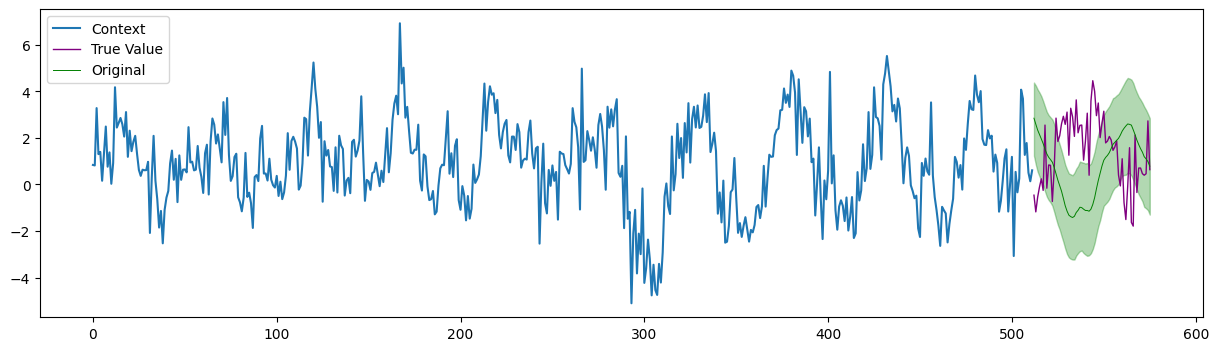

In [15]:
x, y = load_dataset('tsmixup', 4, pred_length=pred_len, ctx_len=context_len)
moirai.module.get_reprs = False
def torch_ds_to_gluonts_listdataset(dataset) -> Generator[dict[str, Any]]:
    def entries():
        for i in range(len(dataset)):
            val_dict = dataset[i]
            x = torch.cat((val_dict['past_values'], val_dict['future_values']))
            # past_vals, future_vals = dataset[i]
            yield {
                "target": x.numpy(),  # array of shape (time,)
                "start": datetime(1970, 1, 1, 0, 0),
                "freq": 'h',
                "item_id": f"item_{i}",
            }

    return ListDataset(entries(), freq='h')
gluonts_ds = torch_ds_to_gluonts_listdataset(val_dataset)

# print(x.shape)
batch_size = 32
predictor = moirai.create_predictor(batch_size=batch_size)
forecasts = predictor.predict(gluonts_ds)

input_it = iter(x)
label_it = iter(y)
forecast_it = iter(forecasts)

start_time = time.time()
for i, (input, label, forecast) in enumerate(zip(input_it, label_it, forecast_it)):
    # print(f"{i} {(time.time()-start_time):.4f}")
    print(forecast.forecast_array.shape)    
    plt.figure(figsize=(15,4))
    plt.plot(input, label="Context")
    plt.plot(np.arange(label.shape[0]) + context_len, label.detach().cpu(), color='purple', label='True Value', lw=1)
    plt.plot(np.arange(forecast.forecast_array.shape[1]) + context_len, forecast.forecast_array[4], color='green', label='Original', lw=0.7)
    plt.fill_between(np.arange(forecast.forecast_array.shape[1]) + context_len, forecast.forecast_array[0], forecast.forecast_array[8], color='green', alpha=0.3)
    plt.legend()
    plt.show()
    break

In [5]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.itertools import batcher
def load_test_data(pred_length, context, quantiles, dataset, forecast_date, stride=1):
    PDT = pred_length
    CTX = context

    # Load dataframe and GluonTS dataset
    df = pd.read_csv(dataset, index_col=0, parse_dates=['ds'])
    df['y'] = df['y'].astype(np.float32)
    # df = pd.read_csv(dataset, index_col=False, parse_dates=['ds'])
    ds = PandasDataset.from_long_dataframe(df, target="y", item_id="unique_id", timestamp='ds')
    freq = ds.freq
    unit = ''.join(char for char in freq if not char.isdigit())
    print(f'freq: {freq}, unit: {unit}')
    unit_str = "".join(filter(str.isdigit, freq))
    if unit_str == "":
        unit_num = 1
    else:
        unit_num = int("".join(unit_str))
    if unit == 'M':
        freq_delta = pd.DateOffset(months=unit_num)
    else:
        freq_delta = pd.Timedelta(unit_num, unit)

    
    if forecast_date == "":
        forecast_date = min(df['ds']) + freq_delta * CTX
    else:
        forecast_date = pd.Timestamp(forecast_date)
    end_date = max(df['ds'])
    if unit == 'M':
        total_forecast_length = (end_date.to_period(unit)-forecast_date.to_period(unit)).n // unit_num + 1
    else:
        total_forecast_length = (end_date-forecast_date) // freq_delta

    _, test_template = split(
        ds, date=pd.Period(forecast_date, freq=freq)
    )

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # number of time steps for each prediction
        windows=total_forecast_length-PDT,  # number of windows in rolling window evaluation
        distance=stride,  # number of time steps between each window - distance=PDT for non-overlapping windows
        max_history=CTX,
    )
    return test_data, freq, unit, freq_delta

freq: H, unit: H
preds: torch.Size([1, 36, 576])
preds reshape: torch.Size([1, 36, 4, 9, 16])
pred_index: tensor([31])
preds reshape 2: torch.Size([1, 4, 9, 16])
forecast custom: torch.Size([1, 9, 64])
forecast fast==custom: True
(512,)
(9, 64)


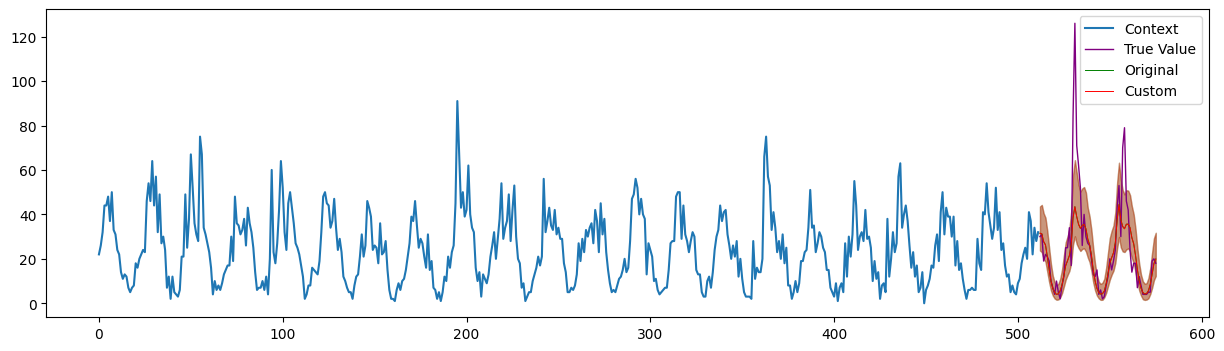

In [ ]:
dataset_name = "amazon-google"
model_name = "moirai2"
# enter entire dataset path to argparse
dataset = f"/extra/datalab_scratch0/ctadler/time_series_models/ts_foundation_calibration/data/{dataset_name}/y_{dataset_name}.csv"
save_dir = f"model_results/{dataset_name}/{model_name}"
forecast_date = "2021-01-31 23:00:00"
stride = 1
batch_size = 512
pred_length = 64
context_len = 512
quantiles = [10,20,30,40,50,60,70,80,90]
test_data, freq, unit, freq_delta = load_test_data(pred_length, context_len, quantiles, dataset, forecast_date, stride=1)
predictor = moirai.create_predictor(batch_size=32)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)


# print(len(forecast_it))
mean_results = []
median_results = []
quantile_results = [[] for _ in quantiles]
start_time = time.time()
for i, (input, label, forecast) in enumerate(zip(input_it, label_it, forecast_it)):
    # print(f"{i} {(time.time()-start_time):.4f}")
    past_target = torch.tensor(input["target"][None, : , None], device='cuda:0')
    # print(f"past target: {past_target.shape}")
    target, observed_mask, sample_id, time_id, variate_id, prediction_mask = moirai._convert(
        patch_size=patch_size,
        past_target=past_target,                                 # B x past_time x D
        past_observed_target=torch.isfinite(past_target),               # B x past_time x D (bool)
        past_is_pad=torch.full_like(past_target[:, :, 0], False, dtype=bool),                                 # B x past_time (bool)
    )
    # moirai_module = moirai.module.to(device)
    moirai.module.get_reprs = False
    moirai.module.eval()
    preds = moirai.module(
        target=target,
        observed_mask=observed_mask,
        sample_id=sample_id,
        time_id=time_id,
        variate_id=variate_id,
        prediction_mask=prediction_mask,
        training_mode=False)
    forecast_fast = einops.rearrange(preds[:,context_len//patch_size-1,:],
                                "B (patches quantiles patch_len) -> B patches quantiles patch_len",
                                quantiles = 9, patch_len = patch_size).detach().cpu()
    forecast_fast = einops.rearrange(forecast_fast, "B patches quantiles patch_len -> B quantiles (patches patch_len)")
    preds = einops.rearrange(
                preds,
                "... (predict_token num_quantiles patch_size) -> ... predict_token num_quantiles patch_size",
                predict_token=4,
                num_quantiles=9,
                patch_size=16,
            )
    print(f"preds reshape: {preds.shape}")
    per_var_context_token = 512 // 16 # 32
    total_context_token = 1 * per_var_context_token # 32
    per_var_predict_token = 64 // 16 # 4

    # In the case of 3 variables, per_var_context_token=3, per_var_predict_token=2.
    # The variate_id is: 0 0 0 1 1 1 2 2 2 [p0] [p0] [p1] [p1] [p2] [p2]
    # pred_index is initialized to be the indices of 2, 5, 8
    # assign_index is initialized to be the indices of 9, 11, 13
    pred_index = torch.arange(
        start=per_var_context_token - 1,
        end=total_context_token,
        step=per_var_context_token,
    ) # [31]
    print(f"pred_index: {pred_index}")
    preds = einops.rearrange(
                preds[..., pred_index, :4, :, :],
                "... pred_index predict_token num_quantiles patch_size -> ... (pred_index predict_token) num_quantiles patch_size",
            )
    print(f"preds reshape 2: {preds.shape}")

    forecast_custom = einops.rearrange(preds, "B patches Q patch_len -> B Q (patches patch_len)").detach().cpu()

    # forecast_custom = moirai.predict(past_target.detach().cpu())
    
    print(f"forecast custom: {forecast_custom.shape}")
    print(f"forecast fast==custom: {torch.all(forecast_fast == forecast_custom)}")

    print(input["target"].shape)
    print(forecast.forecast_array.shape)    
    plt.figure(figsize=(15,4))
    plt.plot(input["target"], label="Context")
    plt.plot(np.arange(label["target"].shape[0]) + context_len, label["target"], color='purple', label='True Value', lw=1)
    plt.plot(np.arange(forecast.forecast_array.shape[1]) + context_len, forecast.forecast_array[4], color='green', label='Original', lw=0.7)
    plt.fill_between(np.arange(forecast.forecast_array.shape[1]) + context_len, forecast.forecast_array[0], forecast.forecast_array[8], color='green', alpha=0.3)
    
    plt.plot(np.arange(forecast_custom[0].shape[1]) + context_len, forecast_custom[0][4], color='red', label='Custom', lw=0.7)
    plt.fill_between(np.arange(forecast_custom[0].shape[1]) + context_len, forecast_custom[0][0], forecast.forecast_array[8], color='red', alpha=0.3)
    plt.legend()
    plt.show()
    break